# Automatsko vodjenje objekata u prostoru

Autor: Djordje Marjanovic

## Zadatak 1

Analizirati primenu metoda paralelnog vođenja u dve tačke u vertikalnoj 
ravni za sledeći scenario:

**Cilj** je letelica i nalazi se u početku na poziciji
$x = 5000\mathrm{m}$, $y = 2500\mathrm{m}$.
Kreće se brzinom $200\frac{\mathrm{m}}{\mathrm{s}}$.
Pocetni ugao elevacije je $0$.
Od početnog trenutka vrši manevar od $1g$ na više.

**Vodjeni objekat** je letelica koja se u pocetnom trenutku nalazi u 
koordinatnom početku. Brzina objekta je sve vreme 
$400\frac{\mathrm{m}}{\mathrm{s}}$. Početno usmerenje vektora brzine objekta
 je $20^\circ$.

Simulirati trajektoriju vođenog objekta i cilja, odrediti krajnji promašaj i
 profil promene normalnog ubrzanja.

### Postavka

In [47]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import control

### Stanja

Za potrebe simulacije, objekat navođenja i cilj se predstavljaju vektorom 
stanja u obliku:

$s = [x, y, v_x, v_y]^T$

### Cilj

Zbog svoje jednostavne prirode, cilj se modelira algebarski sledećim jednačinama

$x_c(t) = x_c(0) + v_{cx} t$

$y_c(t) = y_c(0) + \frac12 a_{cy} t^2$

$v_{cx}(t) = v_{cx}(0)$

$v_{cy}(t) = a_{cy} t$

$s_c(t) = \left[x_c(t), y_c(t), v_{cx}(t), v_{cy}(t)\right]^T$

gde su:
 
$x_{c}(0) = 5000\mathrm{m}$

$y_{c}(0) = 2500\mathrm{m}$ 

$v_{cx}(0) = 200\frac{\mathrm{m}}{\mathrm{s}}$

$a_{cy} = 1g = 9.81\frac{\mathrm{m}}{\mathrm{s}^2}$

In [48]:
def create_target(t):
    x0 = 5000
    y0 = 2500
    vx0 = 200
    ay0 = 9.81
    return (
        x0 + vx0 * t,
        y0 + ay0 * t ** 2 / 2,
        vx0 + 0 * t,
        ay0 * t
    )

### Normalno ubrzanje

Zahtevano normalno ubrzanje za paralelno zbližavanje se može dobiti iz 
ubrzanja potrebnog za paralelno navođnje kada $c\to\infty$.
Da bi se dobila promena ugla $\varepsilon$, koristi se vektor rotacije 
$\mathbf\Omega=\frac{\mathbf R\times\mathbf v_r}{|\mathbf R|^2}$, gde je 
$\mathbf v_r = \mathbf v_t - \mathbf v_o$ i $\mathbf R = \mathbf C - \mathbf O$

Konačna formula je:
 
$\mathbf a = c\mathbf v_o \times 
\frac{\mathbf R\times\mathbf v_r}{|\mathbf R|^2}$

Odnosno, zeljeno normalno ubrzanje je $a_n^*=|\mathbf a|$

Radi praktične implementacije koristi se $c = 20$

In [49]:
def reference_acc(state, target_state):
    if state.shape[0] == 4:
        x, y, vx, vy = state
    else:
        x, y, vx, vy, p0, p1, p2 = state
        
    target_x, target_y, target_vx, target_vy = target_state
    
    R = np.array([target_x - x, target_y - y, 0])
    Vr = np.array([target_vx - vx, target_vy - vy, 0])
    Vo = np.array([vx, vy, 0])
    
    acc = Vr
    acc = np.cross(R, acc)
    acc = np.cross(Vo, acc)
    acc = acc / np.linalg.norm(R) ** 2
    # acc = acc / np.linalg.norm(Vo)
    acc = acc * np.linalg.norm(Vr)
    
    acc_normal = np.array([vy, -vx, 0])
    acc_normal = acc_normal / np.linalg.norm(acc_normal)
    acc_normal = acc.dot(acc_normal)
    
    return acc_normal * 20
    # return 6

### Model letelice

Za model letelice se koristi $\dot s = [v_{ox}, v_{oy}, a_n\cos(\alpha), a_n\sin
(\alpha)]$, gde je $\alpha = \angle(\mathbf v_o, \hat{\mathbf x}) + \frac\pi2$

In [50]:
def model(t, state):    
    acc_normal = reference_acc(state, create_target(t))
    
    x, y, vx, vy = state
    acc_angle = np.arctan2(vy, vx) + np.pi / 2
    acc = {
        'x': acc_normal * np.cos(acc_angle),
        'y': acc_normal * np.sin(acc_angle)
    }
    
    return np.array([vx, vy, acc['x'], acc['y']])

### Simulacija

Simulacija se vrši rešavanjem jednačine $\dot s = \texttt{model}(t, s)$ 
pomoću funkcije `scipy.integrate.solve_ivp`, koja koristi Runge-Kutta metod 
četvrtog reda. 

Za simulaciu se koriste parametri:

$t_{max} = 50\mathrm{s}$

$\Delta t = 0.01\mathrm{s}$

In [51]:
t_max = 50
dt = 0.01
x0, y0 = 0, 0
v0 = 400
angle0 = 20 / 180 * np.pi
vx0, vy0 = v0 * np.cos(angle0), v0 * np.sin(angle0)
t = np.linspace(0, t_max, int(t_max / dt + 1))

Funkcija `end_event` pretstavlja događaj. U slučaju da se cilj i objekat 
približe viš od 50 metara, simulacija se zaustavlja.

In [52]:
def end_event(t, state):
    x, y, vx, vy = state
    target_x, target_y, target_vx, target_vy = create_target(t)
    dist = np.sqrt((target_x - x) ** 2 + (target_y - y) ** 2)
    return dist - 50

end_event.terminal = True

In [53]:
solution = solve_ivp(
    model,
    (0, t_max),
    [0, 0, vx0, vy0],
    t_eval = t,
    events = None
    # events = end_event
)

# If the simulation is ended prematurely, there is no need showing the whole 
# time frame.
t = solution.t

x, y, vx, vy = solution.y
target_x, target_y, target_vx, target_vy = create_target(t) 

### Trajektorija vođenog objekta i cilja

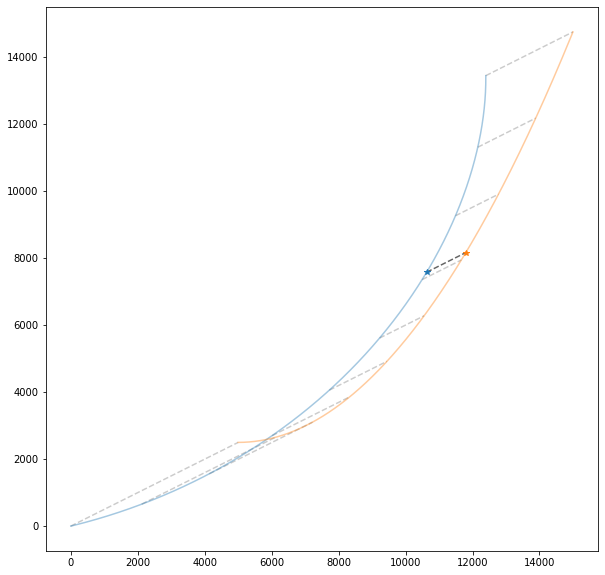

In [54]:
# find the point when the objects are closest to each other
dist = np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
closest_index = np.argmin(dist)

num_parallels = 10

fig, ax = plt.subplots(figsize = (10, 10))

for i in range(num_parallels):
    parallel_index = int(i * (len(t) - 1) / (num_parallels - 1))
    p = plt.plot(
        [x[parallel_index], target_x[parallel_index]],
        [y[parallel_index], target_y[parallel_index]],
        '--k',
        alpha = 0.2
    )

plt.plot(
    [x[closest_index], target_x[closest_index]],
    [y[closest_index], target_y[closest_index]],
    '--k',
    alpha = 0.6
)

plt.plot(x, y, alpha = 0.4, c='C0')
plt.plot([x[closest_index]], [y[closest_index]], '*', c='C0')

plt.plot(target_x, target_y, alpha = 0.4, c='C1')
plt.plot([target_x[closest_index]], [target_y[closest_index]], '*', c='C1')
ax.set_aspect('equal')
plt.show()

task1 = {
    "time": t,
    "trajectory": (x, y),
}

### Krajnji promašaj

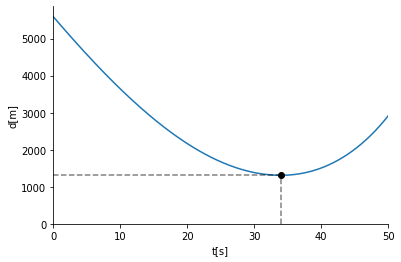

Minimal distance is 1309.077m


In [55]:
min_index = np.argmin(dist)
d_min = dist[min_index]
t_min = t[min_index]

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(t, dist)
plt.plot([t_min, t_min], [0, d_min], '--k', alpha=0.5)
plt.plot([0, t_min], [d_min, d_min], '--k', alpha=0.5)
plt.plot([t_min], [d_min], 'ok')
plt.xlabel('t[s]')
plt.ylabel('d[m]')
plt.xlim(0, 50)
plt.ylim(0, np.max(dist) * 1.05)
plt.show()

print("Minimal distance is {:.03f}m".format(d_min))

task1['dist'] = dist
task1['d_min'] = d_min
task1['t_min'] = t_min

### Profil promene normalnog ubrzanja

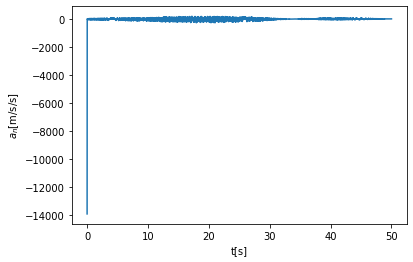

In [56]:
target_x0, target_y0, target_vx0, target_vy0 = create_target(0)
e0 = np.arctan2(target_y0, target_x0) 
control_t = np.zeros((t.shape))
for i, time in enumerate(t):
    control_t[i] = reference_acc(solution.y[:, i], create_target(time))

# plt.plot(t, control(solution.y, target.T, e0))
plt.plot(t, control_t)
plt.xlabel('t[s]')
plt.ylabel('$a_n$[m/s/s]')
plt.show()

task1['acc'] = control_t

### Profil promene ugla viziranja

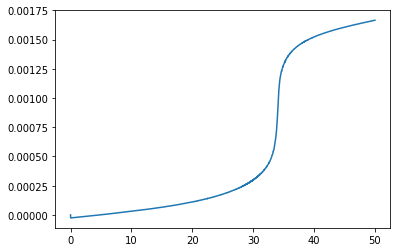

In [58]:
e = np.arctan2(target_y - y, target_x - x)

plt.plot(t, e - e0)
plt.show()

## Zadatak 2

U sklopu sistema vođenja definisanog u domaćem zadatku 1. simulirati efekte 
realnog trekera, dinamičkog modela objekta vođenja i autopilota.

Sve slučajeve samonavođenja posmatrati kao proporcionalnu navigaciju sa 
odgovarajućim vrednostima navigacione konstante. Za paralelno zbližavanje 
usvojiti $C = 20$.

U slučajevima u kojima je zadatak bio da se simulira adjungovani sistem, 
posmatrati ponašanje originalnog sistema.

1. **Dinamički model objekta vođenja**

Definisan je dinamičkim parametrima:

* $K = 0.75$
* $T_1 = 1\mathrm{s}$
* $\omega_n = 20\frac{\mathrm{rad}}{\mathrm{s}}$
* $\zeta = 0.1$


2. **Autopilot**

Definisati strukturu autopilota namenjenog za upravljanje normalnim ubrzanjem.

Naponski signali su limitirani na $\pm 10 V$

Zanemariti dinamiku pokretača krmila.

Hod krmila je limitiran na $\pm20^\circ$


3. **Treker u sistemima koji realizuju komandno vođenje primeniti samo na 
praćenje cilja.**

*ova tacka se preskace*

Servo sistem trekera je na bazi elektromotornog pogona.

Parametri motora i inercije platforme su:

* $T_{\mathrm{motora}} = 0.5\mathrm{s}$
* $T_{\mathrm{platforme}} = 0.5\mathrm{s}$

Kontroler je PI tipa.

Primeniti kolo unutrašnje povratne sprege po signalu sa tahogeneratora.

Simulirati dejstvo termičkog šuma u senzoru za praćenje.

4. **Treker u sistemima koji realizuju samonavođenje**

Realizovan na bazi teškog precesionog žiroskopa sa tork motorom čija se 
inercija može zanemariti.

Usvojiti da je hod glave za samonavođenje mehanički ograničen na $\pm60^\circ$, 
a da je vidno polje senzora ograničeno na $\pm30^\circ$.

Simulirati dejstvo termičkog šuma u senzoru za praćenje.

### Parametri

Zajednički parameteri koji se koriste često u ostatku koda.

In [59]:
parameters = {
    "K": 0.75,
    "T1": 1,
    "omegan": 20,
    "zeta": 0.1,
    "Ksg": 5,
    "Kacc": 1,
    "Vo": 200
}

### Objekat vođenja

Za objekat vođenja koristi se model drugog reda u obliku:

$M = \frac{K(T_1s+1)}{\frac{4\pi^2}{\omega_n^2}s^2 + 
\frac{4\pi\zeta}{\omega_n} + 1}$ 

In [60]:
def model():
    K = parameters['K']
    T1 = parameters['T1']
    omegan = parameters['omegan']
    zeta = parameters['zeta']
    T = 2 * np.pi / omegan
    
    return control.TransferFunction([K * T1, K], [T**2, 2 * T * zeta, 1])
    
print(model())


      0.75 s + 0.75
--------------------------
0.0987 s^2 + 0.06283 s + 1



### Autopilot

Za autopilota se koristi sistem prikazan ispod

![](autopilot.svg)

Gde je $L = \frac{v_o}{T_1s+1}$

Povratna sprega po brzinskom žiroskopu je $I = \frac{M}{1 + K_{sg}M}$.

Povratna sprega po akcelerometru je $F = \frac{AI}{1+K_{acc}AI}$

In [61]:
def autopilot():
    T1 = parameters['T1']
    Vo = parameters['Vo']
    Ksg = parameters['Ksg']
    Kacc = parameters['Kacc']
    
    M = model()
    L = control.TransferFunction([Vo], [T1, 1])
    
    I = M / (1 + M * Ksg)
    F = I * L / (1 + I * L * Kacc)
    
    return control.minreal(F)

print(autopilot())

8 states have been removed from the model

        1520
--------------------
s^2 + 38.63 s + 1568



### Treker

Pošto se koristi algoritam za samonavođenje, po tekstu zadatka, potrebno je 
koristiti treker na bazi teškog precesionog žiroskopa sa tork motorm čija se 
inercija može zanemariti. To znači da se parametri $\tau_1$ i $\tau_2$ u šemi 
za treker, prikazanoj ispod, mogu zanemariti, pa se za prenosnu funkciju 
dobija $T = \frac{1}{\frac{H}{K_1K_2}s + 1}$.

![](tracker.svg)

In [62]:
def tracker():
    K1 = K2 = H = 10
    K = K1 * K2 / H
    T = control.TransferFunction([K], [1, 0])
    
    return T / (1 + T)

print(control.minreal(tracker()))

1 states have been removed from the model

  10
------
s + 10



### Potpun sistem upravljanja objektom

Potpun sistem upravjlanja se dobija kombinovanjem trekera i autopilota. 

8 states have been removed from the model
1 states have been removed from the model

1.421e-14 s^2 - 1.137e-12 s + 1.52e+04
--------------------------------------
 s^3 + 48.63 s^2 + 1954 s + 1.568e+04



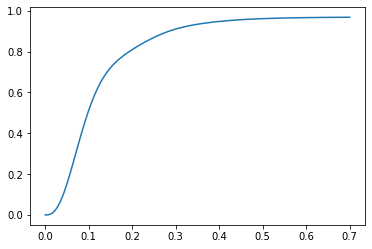

In [63]:
def object():
    T = tracker()
    A = autopilot()
    
    return control.tf2ss(control.minreal(T * A))

O = object()
print(control.ss2tf(O))
t, y = control.step_response(O)
plt.plot(t, y)
plt.show()


### Model letelice

Za razliku od prvog zadatka, dodaju se nova stanja koja proizilaze od uvedenog 
modela trekera i autopilota. Nova stanja su obeležena kao $p$ i njihov model 
u prostoru stanja je definisan jednačinama:

$\dot p = A_pp + B_pa_n^*$

$a_n = C_pp + D_pa_n^*$

Gde su $A_p$, $B_p$, $C_p$ i $D_p$ vrednosti sistema sa trekerom i 
autopilotem. $a_n^*$ je željeno normalno ubrzanje, a $a_n$ je ostvareno 
normalno ubrzanje.

In [64]:
target_x, target_y, target_vx, target_vy = create_target(0)
e0 = np.arctan2(target_y, target_x)

def model(t, state):
    x, y, vx, vy, p0, p1, p2 = state
    p = np.array([[p0], [p1], [p2]])
    
    acc_normal = reference_acc(state, create_target(t))
    p_prime = O.A.dot(p) + O.B.dot(acc_normal)
    acc_hat = O.C.dot(p) + O.D.dot(acc_normal)
    
    acc_angle = np.arctan2(vy, vx) + np.pi / 2
    acc = {
        'x': acc_hat * np.cos(acc_angle),
        'y': acc_hat * np.sin(acc_angle)
    }
    
    return np.array([
        vx, vy, acc['x'], acc['y'], p_prime[0], p_prime[1], p_prime[2]
    ])

### Simulacija

Simulacija je izvršena isto kao u prvom zadatku, sa dodatno proširenim 
vektorom stanja.

In [65]:
t_max = 50
dt = 0.01
x0, y0 = 0, 0
v0 = 400
angle0 = 20 / 180 * np.pi
vx0, vy0 = v0 * np.cos(angle0), v0 * np.sin(angle0)
t = np.linspace(0, t_max, int(t_max / dt + 1))

In [66]:
def end_event(t, state):
    x, y, vx, vy, p0, p1, p2 = state
    target_x, target_y, target_vx, target_vy = create_target(t)
    dist = np.sqrt((target_x - x) ** 2 + (target_y - y) ** 2)
    return dist - 50

end_event.terminal = True

In [67]:
solution = solve_ivp(
    model,
    (0, t_max),
    [0, 0, vx0, vy0, 0, 0, 0],
    t_eval = t,
    events = None
    # events = end_event
)
t = solution.t
x, y, vx, vy, p0, p1, p2 = solution.y
target_x, target_y, target_vx, target_vy = create_target(t) 


### Trajektorija vođenog objekta i cilja

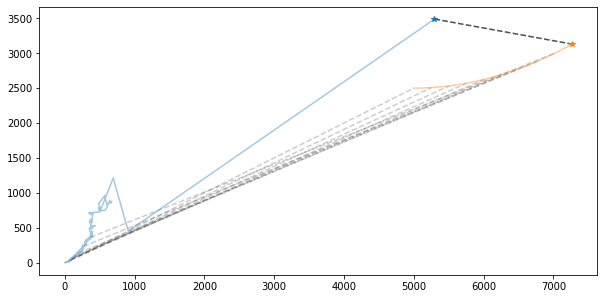

In [68]:
# find the point when the objects are closest to each other
dist = np.sqrt((x - target_x) ** 2 + (y - target_y) ** 2)
closest_index = np.argmin(dist)

num_parallels = 10

fig, ax = plt.subplots(figsize = (10, 10))

for i in range(num_parallels):
    parallel_index = int(i * (len(t) - 1) / (num_parallels - 1))
    p = plt.plot(
        [x[parallel_index], target_x[parallel_index]],
        [y[parallel_index], target_y[parallel_index]],
        '--k',
        alpha = 0.2
    )

plt.plot(
    [x[closest_index], target_x[closest_index]],
    [y[closest_index], target_y[closest_index]],
    '--k',
    alpha = 0.6
)

plt.plot(x, y, alpha = 0.4, c='C0')
plt.plot([x[closest_index]], [y[closest_index]], '*', c='C0')

plt.plot(target_x, target_y, alpha = 0.4, c='C1')
plt.plot([target_x[closest_index]], [target_y[closest_index]], '*', c='C1')
ax.set_aspect('equal')
plt.show()

task2 = {
    "time": t,
    "trajectory": (x, y),
}

### Krajnji promašaj

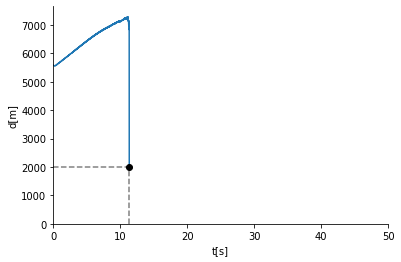

Minimal distance is 2003.742m


In [69]:
min_index = np.argmin(dist)
d_min = dist[min_index]
t_min = t[min_index]

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(t, dist)
plt.plot([t_min, t_min], [0, d_min], '--k', alpha=0.5)
plt.plot([0, t_min], [d_min, d_min], '--k', alpha=0.5)
plt.plot([t_min], [d_min], 'ok')
plt.xlabel('t[s]')
plt.ylabel('d[m]')
plt.xlim(0, 50)
plt.ylim(0, np.max(dist) * 1.05)
plt.show()

print("Minimal distance is {:.03f}m".format(d_min))

task2['dist'] = dist

### Profil promene normalnog ubrzanja

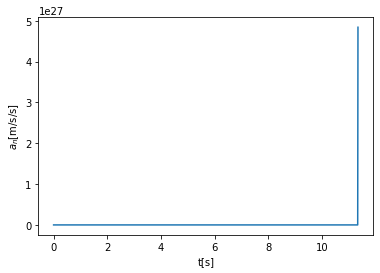

In [70]:
target_x0, target_y0, target_vx0, target_vy0 = create_target(0)
e0 = np.arctan2(target_y0, target_x0) 
control_t = np.zeros((t.shape))
for i, time in enumerate(t):
    control_t[i] = reference_acc(solution.y[:, i], create_target(time))

# plt.plot(t, control(solution.y, target.T, e0))
plt.plot(t, control_t)
plt.xlabel('t[s]')
plt.ylabel('$a_n$[m/s/s]')
plt.show()

task2['acc'] = control_t

## Poređenje prvog i drugog zadatka

### Trajektorija vođenog objekta i cilja

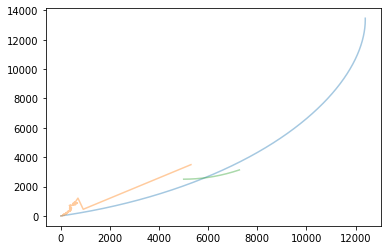

In [71]:
x, y = task1['trajectory']
plt.plot(x, y, alpha = 0.4, c='C0')
x, y = task2['trajectory']
plt.plot(x, y, alpha = 0.4, c='C1')
plt.plot(target_x, target_y, alpha = 0.4, c='C2')
ax.set_aspect('equal')
plt.show()

### Krajnji promašaj

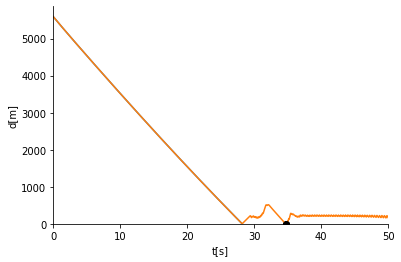

Minimal distance is 0m


In [162]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

t = task1['time']
dist = task1['dist']
plt.plot(t, dist)
plt.plot([t_min], [d_min], 'ok')

t = task2['time']
dist = task2['dist']
plt.plot(t, dist)
plt.plot([t_min], [d_min], 'ok')

plt.xlabel('t[s]')
plt.ylabel('d[m]')
plt.xlim(0, 50)
plt.ylim(0, np.max(dist) * 1.05)
plt.show()

print("Minimal distance is {:.00f}m".format(d_min))

### Profil promene normalnog ubrzanja

ValueError: x and y must have same first dimension, but have shapes (5001,) and (2821,)

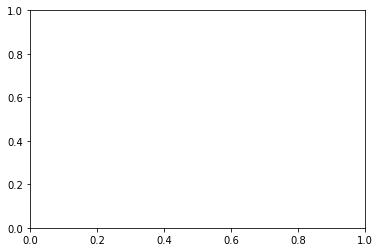

In [163]:
plt.plot(t, task1['acc'])
plt.plot(t, task2['acc'])
plt.xlabel('t[s]')
plt.ylabel('$a_n$[m/s/s]')
plt.show()
